In [8]:
from langgraph.graph import StateGraph
from typing import Dict,Any,TypedDict, List
from IPython.display import Image, display

In [40]:
class PCTTestcase(TypedDict):
    All_Test_Case:List[Any]
    Testcase_count: int
    PCT_TC_list: List[Any]
    Test_results: List[Any]
    Filed_testcase: List[Any]
    Passed_testcase: List[Any]
    Iteration: int
    attempts:int
    final:str

MAX_ATTEMPTS = 2


In [41]:
def get_me_list_of_test(state: Dict[str, Any]) -> Dict[str, Any]:
    get_test_list = state.get("All_Test_Case", [])
    PCTlist = [i for i in get_test_list if "PCT" in i]

    state["Testcase_count"] = len(PCTlist)
    state["PCT_TC_list"] = PCTlist

    # Initialize counters only once
    state["Iteration"] = state.get("Iteration", 1)
    state["attempts"] = state.get("attempts", 0)

    print(f"Found {len(PCTlist)} PCT testcases → {PCTlist}")
    return state



#{'PCT_TC_list': ['PDT1', 'PCT', 'PDT', 'PFT', 'PCT1'], 'Test_results': {'PDT1': 'PASSED', 'PCT': 'PASSED', 'PDT': 'PASSED', 'PFT': 'PASSED', 'PCT1': 'PASSED'}}

def run_and_get_results(state: Dict[str, Any]) -> Dict[str, Any]:
    results = {}
    PCTlist = state.get("PCT_TC_list", [])

    # Simulate all passed initially
    for test in PCTlist:
        results[test] = "PASSED"

    state["Test_results"] = results

    print(f"Executing {state['Testcase_count']} testcases…")
    return state


# {'PCT_TC_list': ['PDT1', 'PCT', 'PDT', 'PFT', 'PCT1'], 'Test_results': {'PDT1': 'PASSED', 'PCT': 'PASSED', 'PDT': 'PASSED', 'PFT': 'FAILED', 'PCT1': 'PASSED'}, 
#'Filed_testcase': ['PFT']}

def check_results(state: Dict[str, Any]) -> Dict[str, Any]:
    state["Filed_testcase"] = []
    state["Passed_testcase"] = []

    for test, result in state["Test_results"].items():
        if result == "FAILED":
            state["Filed_testcase"].append(test)
        else:
            state["Passed_testcase"].append(test)

    print(
        f"Passed: {state['Passed_testcase']}, "
        f"Failed: {state['Filed_testcase']}"
    )
    return state


def check_all_passed(state: Dict[str, Any]) -> Dict[str, Any]:
    if len(state["Filed_testcase"]) == 0:
        state["final"] = "All testcases passed!"
        print(state["final"])
        return state   # finish node executes

    # failed case → return state but not final
    print("Some testcases failed → proceeding to retry.")
    return state

    
def rerun_testcase_add_attempt(state: Dict[str, Any]) -> Dict[str, Any]:
    print(f"Rerunning failed testcases, attempt {state['attempts'] + 1}")

    # FIX FAILED TESTCASES
    for tc in state["Filed_testcase"]:
        state["Test_results"][tc] = "PASSED"

    state["attempts"] += 1
    return state

def check_failed_condition(state):
    if len(state["Filed_testcase"]) == 0:
        return "check_all_passed"  # This means FINISH, not loop
    if state["attempts"] >= MAX_ATTEMPTS:
        return "check_all_passed"
    return "rerun_testcase_add_attempt"



In [42]:
builder=StateGraph(PCTTestcase)

builder.add_node('get_me_list_of_test',get_me_list_of_test)
builder.add_node('run_and_get_results',run_and_get_results)
builder.add_node('check_results',check_results)
builder.add_node('rerun_testcase_add_attempt',rerun_testcase_add_attempt)
builder.add_node('check_all_passed',check_all_passed)



In [43]:
builder.set_entry_point("get_me_list_of_test")
builder.add_edge("get_me_list_of_test", "run_and_get_results")
builder.add_edge("run_and_get_results", "check_results")
builder.add_edge("check_results", "check_all_passed")

builder.add_conditional_edges(
    "check_all_passed",
    check_failed_condition,
    {
        "rerun_testcase_add_attempt": "rerun_testcase_add_attempt"
    }
)

builder.add_edge("rerun_testcase_add_attempt", "run_and_get_results")
builder.set_finish_point("check_all_passed")


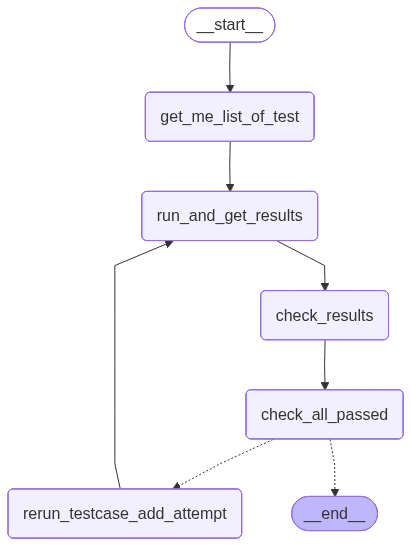

In [44]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
state = {
    "All_Test_Case": ['PDT1', 'PCT', 'PDT', 'PFT', 'PCT1'],

    "Testcase_count": 0,
    "PCT_TC_list": [],

    "Filed_testcase": [],
    "Passed_testcase": [],

    "Test_results": {},   # ← MUST BE A DICTIONARY

    "Iteration": 1,       # usually start from 1
    "attempts": 0,

    "Final": ""           # ← MUST BE a string, not the type `str`
}


result = graph.invoke(state)


Found 2 PCT testcases → ['PCT', 'PCT1']
Executing 2 testcases…
Passed: [], Failed: ['PCT', 'PCT1']
Some testcases failed → proceeding to retry.
Rerunning failed testcases, attempt 1
Executing 2 testcases…
Passed: [], Failed: ['PCT', 'PCT1']
Some testcases failed → proceeding to retry.
Rerunning failed testcases, attempt 2
Executing 2 testcases…
Passed: [], Failed: ['PCT', 'PCT1']
Some testcases failed → proceeding to retry.


KeyError: 'check_all_passed'

In [45]:
state = {
    "All_Test_Case": ['PDT1', 'PCT', 'PDT', 'PFT', 'PCT1'],

    "Testcase_count": 0,
    "PCT_TC_list": [],

    "Filed_testcase": [],
    "Passed_testcase": [],

    "Test_results": {},   # ← MUST BE A DICTIONARY

    "Iteration": 1,       # usually start from 1
    "attempts": 0,

    "Final": ""           # ← MUST BE a string, not the type `str`
}


result = graph.invoke(state)


Found 2 PCT testcases → ['PCT', 'PCT1']
Executing 2 testcases…
Passed: ['PCT', 'PCT1'], Failed: []
All testcases passed!


KeyError: 'check_all_passed'